In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import fastai

In [3]:
path = Path(".")
path_lbl = path/'tr_mask'
path_img = path/'tr_im'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('tr_im/tr_im_z036.png'),
 PosixPath('tr_im/tr_im_z015.png'),
 PosixPath('tr_im/tr_im_z061.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('tr_mask/tr_mask_z016.png'),
 PosixPath('tr_mask/tr_mask_z038.png'),
 PosixPath('tr_mask/tr_mask_z034.png')]

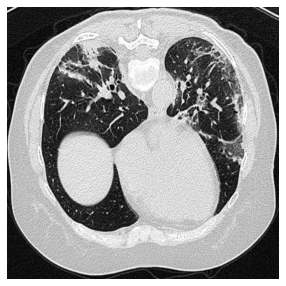

In [6]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: path_lbl/f'tr_mask_{x.stem.split("_")[2]}{x.suffix}'

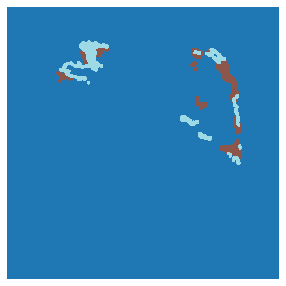

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [9]:
def unique(tensor1d):
    t, idx = np.unique(tensor1d.numpy(), return_inverse=True)
    return torch.from_numpy(t), torch.from_numpy(idx) 

In [10]:
codes = np.arange(0,256,1, np.int16)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16270MB of GPU RAM free


In [13]:
np.random.seed(2)
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

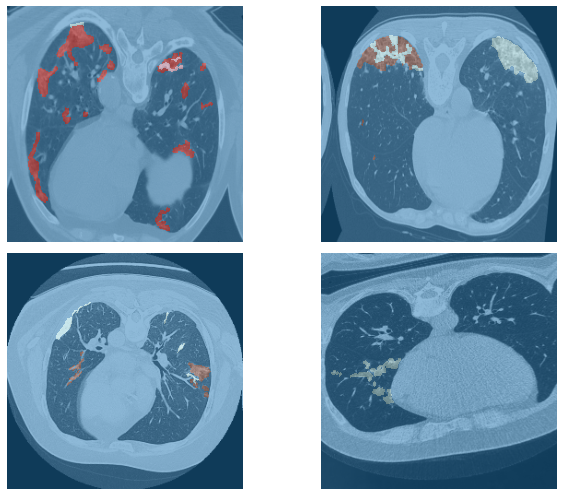

In [15]:
data.show_batch(2, figsize=(10,7))

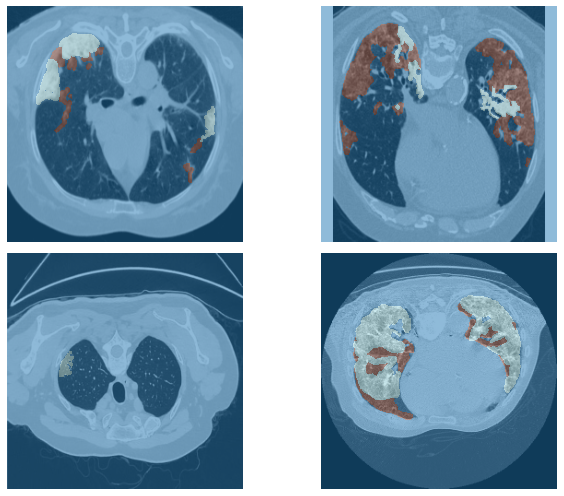

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
wd=1e-2

In [18]:
def dice_(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    dice_sum = torch.as_tensor([0.], dtype=torch.float32, device=targs.device)
    for i in range(1, targs.max()+1):
        input_flatten = input[:,i-1,:,:].flatten(1,-1).float()
        targs_flatten = targs.flatten(1,-1).float()
        input_flatten[input_flatten>0.5], input_flatten[input_flatten<=0.5] = 1., 0.
        targs_flatten[targs_flatten!=i], targs_flatten[targs_flatten==i] = 0, 1
        intersect = (input_flatten * targs_flatten).sum(dim=1)
        union = (input_flatten + targs_flatten).sum(dim=1)
        if not iou: l = 2. * intersect / union
        else: l = intersect / (union-intersect+eps)
        l[union == 0.] = 1
        dice_sum += l.mean()
    return dice_sum / targs.max()

In [19]:
bs = 2
learn = unet_learner(data, models.resnet50, metrics=[dice_, accuracy], wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


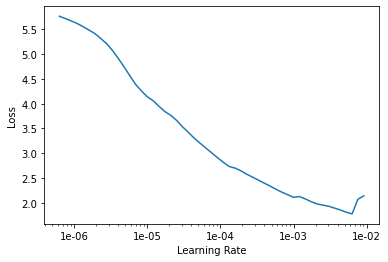

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=3e-3

In [22]:
for i in range(10):
    if torch.cuda.is_available():
        learn.fit_one_cycle(1, slice(lr), pct_start=0.9)
    else:
        fastai.device = torch.device('cpu')
        learn.fit_one_cycle(1, slice(lr), pct_start=0.9)
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_,accuracy,time
0,4.223561,1.520642,0.630784,0.032480,00:20


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.587970,0.525919,0.812745,0.036318,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.388302,0.450760,0.921569,0.037910,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.296044,0.334251,0.960980,0.038905,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.260014,0.293234,0.968627,0.038297,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.233471,0.298603,0.968824,0.038321,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.228611,0.364017,0.967451,0.038308,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.282681,0.324917,0.971176,0.038325,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.251854,0.271211,0.972941,0.038326,00:17


epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.225514,0.287150,0.972745,0.038322,00:17


In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1');

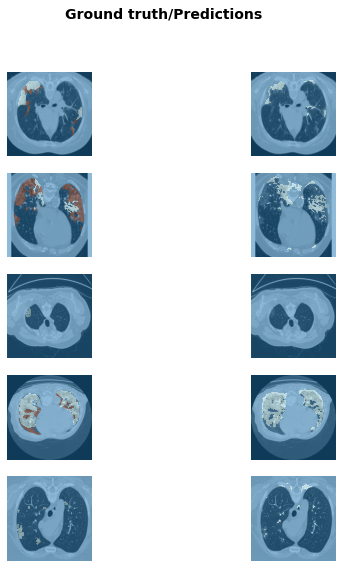

In [25]:
learn.show_results(rows=5, figsize=(8,9))

In [26]:
learn.unfreeze()

In [27]:
lrs = slice(lr/400,lr/4)

In [28]:
bs=1
for i in range(12):
    if torch.cuda.is_available():
        print(fastai.device)
        learn.fit_one_cycle(1, lrs, pct_start=0.9)
    else:
        fastai.device = torch.device('cpu')
        print(fastai.device)
        learn.fit_one_cycle(1, lrs, pct_start=0.9)
# learn.fit_one_cycle(12, lrs, pct_start=0.8)

AttributeError: module 'fastai' has no attribute 'device'

In [29]:
learn.save('stage-2');

In [30]:
learn.load('stage-2');

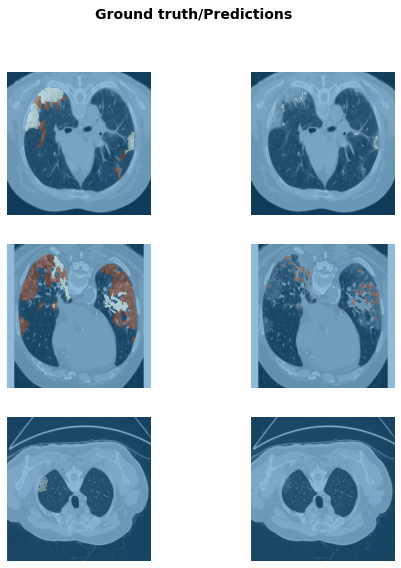

In [31]:
learn.show_results(rows=3, figsize=(8,9))

In [32]:
lrs = slice(lr)

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice_,accuracy,time
0,0.198585,0.240696,0.976863,0.038461,00:04
1,0.197330,0.249819,0.976863,0.038297,00:04
2,0.195600,0.296074,0.976863,0.038295,00:04
3,0.194210,0.278419,0.976863,0.038331,00:04
4,0.199754,0.313316,0.976863,0.038232,00:05
5,0.206811,0.293281,0.976863,0.038589,00:04
6,0.218731,0.498933,0.976863,0.038117,00:04
7,0.261329,7.522241,0.976863,0.038313,00:04
8,0.269371,0.959507,0.976863,0.038306,00:04
9,0.498655,0.417783,0.980784,0.037987,00:04


In [35]:
learn.save('stage-3')

In [37]:
learn.load('stage-3');

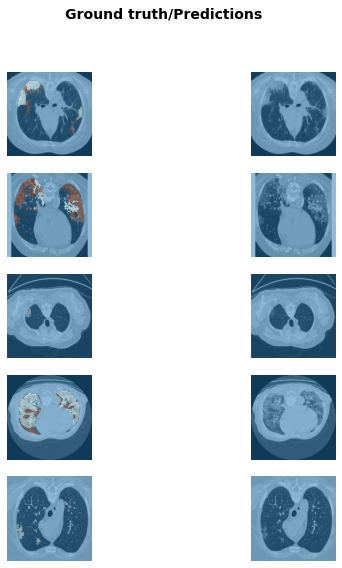

In [39]:
learn.show_results(rows=5, figsize=(8,9))